In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import xarray as xr
from analysis.dataset_manipulation import plot_dataset
from scipy.constants import *
font = {'family':'serif',
        'weight': 'normal',
        'size': 32}
plt.rc('font',**font)
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#000000','#e3130f','#0962f6',
                                                    '#20c168','#fc76f3','#2efef4'])
plt.rc('text',usetex=True)
def fit(x, a, b, c):
    return a*x**2 + b*x + c

def lin(x, m, c):
    return m*x + c

t_dep = 50*60 #50 minutes

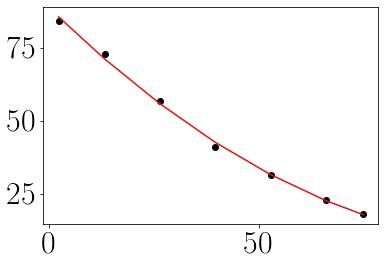

In [16]:
d = pd.read_csv('./Co_wedge_calib.csv')
dist = d.s*2.2#dist from bottom in mm
popt, pcov = curve_fit(fit, dist, d.t)
plt.plot(dist, d.t, 'o')
plt.plot(dist, fit(dist, *popt))

Calculate deposition times

In [17]:
r0 = 0.0106
r1 = fit(90, *popt)/t_dep
r2 = fit(10, *popt)/t_dep
d1, d2 = 0.4, 1.2 

t_w = (d2-d1)/(r2-r1)
t_rot = (d1 - r1*t_w)/r0
print(f't_wedge: {t_w} s, t_rot: {t_rot} s')
print(f'rate 1: {fit(90, *popt)/t_dep} nm/s, rate 2: {fit(5, *popt)/t_dep} nm/s')

t_thin, t_thick = r1*t_w + r0*t_rot, r2*t_w + r0*t_rot, 
print(f'thin: {t_thin} nm, thick: {t_thick} nm')

t_wedge: 37.94601103291354 s, t_rot: 23.55742350882777 s
rate 1: 0.003960661653633797 nm/s, rate 2: 0.027235260112249735 nm/s
thin: 0.4 nm, thick: 1.2 nm


Expected thickness

Text(0.5, 0, 'd (mm)')

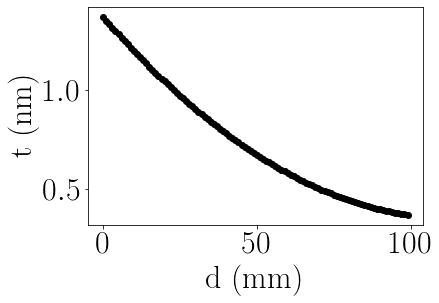

In [18]:
x = np.arange(0, 100, 1)
rates = fit(x, *popt)/t_dep
thickness = t_w*rates + t_rot*r0
plt.plot(x, thickness, 'o')
plt.ylabel('t (nm)')
plt.xlabel('d (mm)')

trot = 24
twedge = 38

## 4 Point Resistance

In [19]:
def t(x):
    rates = fit(x, *popt)/t_dep
    return t_w*rates + t_rot*r0

In [20]:
t_offsets = [4, 0.35]
Ls = [26, 66]
files = ['./R_mid.csv', './R_btm.csv']
dfs = [pd.read_csv(file, index_col='Die') for file in files]
dses = [xr.Dataset(df).assign_coords({'L':Ls[i], 'W':20}) for i, df in enumerate(dfs)]
dses = [ds.assign_coords(t = t((9-ds.Die)*11 + t_offsets[i])).swap_dims({'Die':'t'}) for i, ds in enumerate(dses)]
dses = [ds.assign(cond = ds.L/(ds.R*ds.W)) for i, ds in enumerate(dses)] #con = L/RW
comb_ds = xr.concat(dses, 't').sortby('t')

sigma_co = 10428687.59985102 +/- 102981.96920713825 1/ohm meter
sigma_pt = 578210.4604668675 +/- 27629.95797298166 1/ohm meter


Text(0.5, 0, '$t_{\\rm{Co}}$ (nm)')

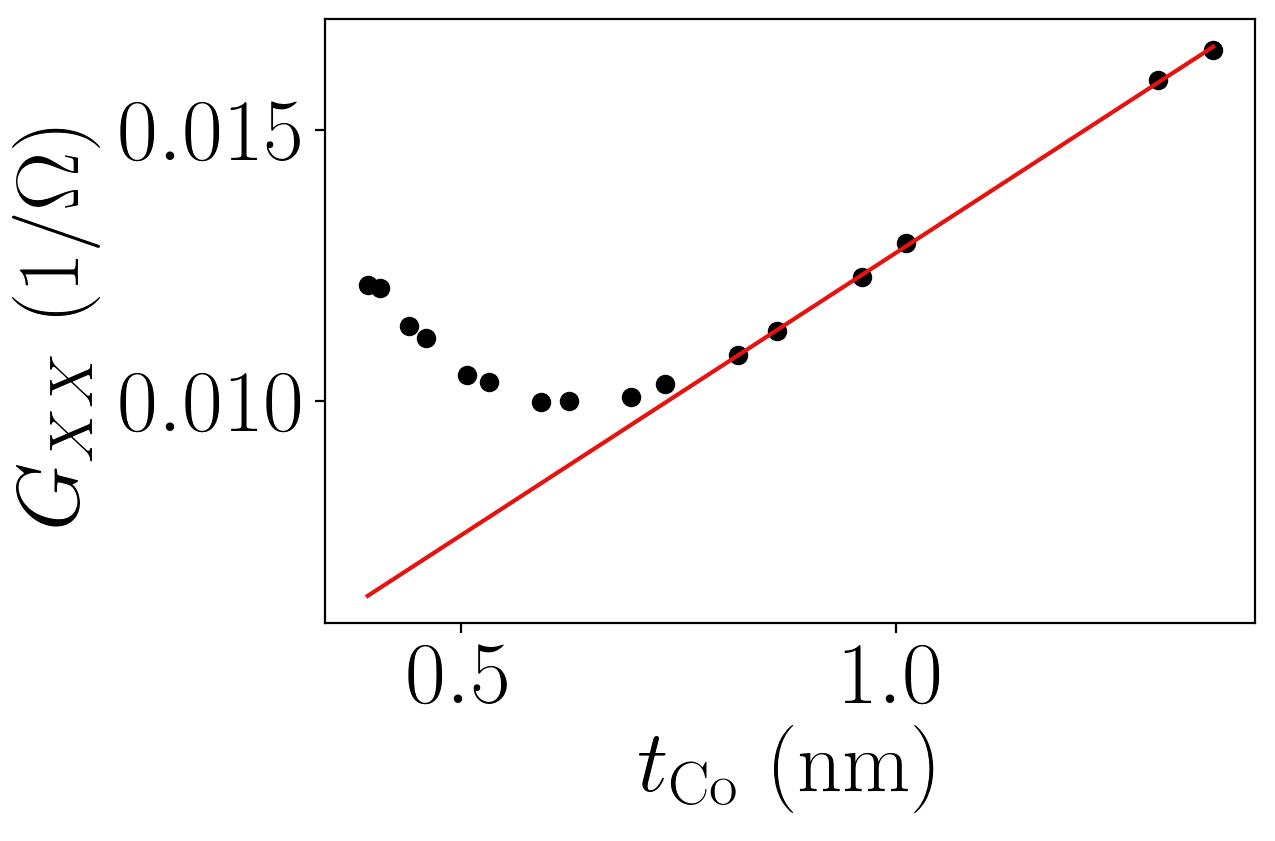

In [26]:
plt.figure(dpi=200)
y = comb_ds.where(comb_ds.t > 0.8, drop=True).cond
x = comb_ds.where(comb_ds.t > 0.8, drop=True).t*1e-9
popt2, pcov2 = curve_fit(lin, x, y)
perr2 = np.sqrt(np.diag(pcov2))

plt.plot(comb_ds.t, comb_ds.cond, 'o',color='k')
plt.plot(comb_ds.t, lin(comb_ds.t*1e-9, *popt2),color='#e3130f')
print(f'sigma_co = {popt2[0]} +/- {perr2[0]} 1/ohm meter')
print(f'sigma_pt = {popt2[1]/4e-9} +/- {perr2[1]/4e-9} 1/ohm meter')
plt.ylabel('$G_{XX}$ (1/$\\Omega$)')
plt.xlabel('$t_{\\rm{Co}}$ (nm)')

sigma_pt = 7247330.467243152 1/ohm meter


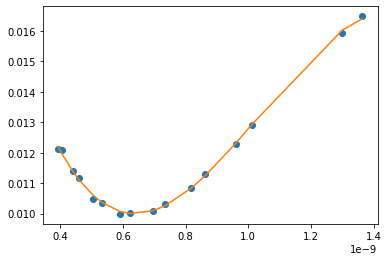

In [10]:
coeffs = np.polyfit(comb_ds.t*1e-9, comb_ds.cond, 3)
plt.plot(comb_ds.t*1e-9, comb_ds.cond, 'o')
plt.plot(comb_ds.t*1e-9, np.polyval(coeffs, comb_ds.t*1e-9))
print(f'sigma_pt = {coeffs[3]/4e-9} 1/ohm meter')

# VSM

In [9]:
mass = 9.05e-3 #g
rho_Si, rho_SiO2= 2.33, 2.65 #g/cm3
t_Si, t_SiO2= 0.05, 3e-7 #cm
A = mass/(rho_Si*t_Si + rho_SiO2*t_SiO2)
print(A)
print(np.sqrt(A)) #film Area

0.07768187332970561
0.2787146808650481


In [10]:
nums = np.arange(1, 9, 1).tolist()
#BG from sample holder
blank = pd.read_csv('./VSM/Blank.DAT', skiprows=34, index_col='Magnetic Field (Oe)')

#Import Data
dfs = [pd.read_csv(f'./VSM/S{i}.Dat', skiprows=34, index_col='Magnetic Field (Oe)').head(65) for i in nums]
dses = [xr.Dataset(df).assign_coords(die = i+1) for i, df in enumerate(dfs)]
lengths = [len(ds['Moment (emu)']) for ds in dses]

#remove sample holder contribution
dses = [ds.assign(Moment_bgrmv = ds['Moment (emu)'] - np.array(blank['Moment (emu)'])[:lengths[i]]) for i, ds in enumerate(dses)]

#Remove linear bg
ds_list = []
for ds in dses:
    x = ds['Magnetic Field (Oe)'][:35]
    y = ds['Moment_bgrmv'][:35]
    popt3, pcov3 = curve_fit(lin, x, y)
    ds_list.append(ds.assign(Moment_flat = ds['Moment_bgrmv'] - ds['Magnetic Field (Oe)']*popt3[0]))

#get step
ds_list2 = []
for ds in ds_list:
    lims = [50, 800]
    upper = ds.where(ds['Magnetic Field (Oe)'] > lims[0]).where(ds['Magnetic Field (Oe)'] < lims[1], drop=True)['Moment_flat']
    low = ds.where(ds['Magnetic Field (Oe)'] < -lims[0]).where(ds['Magnetic Field (Oe)'] > -lims[1], drop=True)['Moment_flat']
    ds_list2.append(ds.assign(step = upper.mean('Magnetic Field (Oe)') - low.mean('Magnetic Field (Oe)')).assign(step_err = np.sqrt(upper.std('Magnetic Field (Oe)')**2 + low.std('Magnetic Field (Oe)')**2)))
    
comb_ds = xr.concat(ds_list2, 'die')
comb_ds = comb_ds.assign(thickness = t((9 - comb_ds.die)*11 - 1.5))
comb_ds = comb_ds.assign(V = comb_ds.thickness*1e-7*A) #square is 0.108inches, 2.74mm
# comb_ds = comb_ds.assign(t_normalized_step = comb_ds.step/comb_ds.thickness)
# comb_ds = comb_ds.assign(t_normalized_step_err = comb_ds.step_err/comb_ds.thickness)

#conversion to T mu_0*1e3*(step in emu)/2.
comb_ds = comb_ds.assign(M = mu_0*1e3*comb_ds.step/2./(comb_ds.V))
comb_ds = comb_ds.assign(M_err = mu_0*1e3*comb_ds.step_err/2./(comb_ds.V))

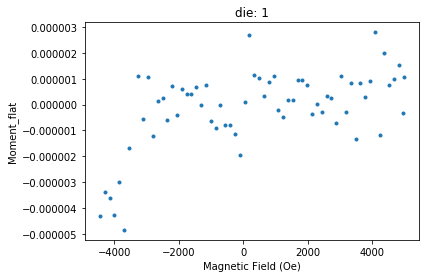

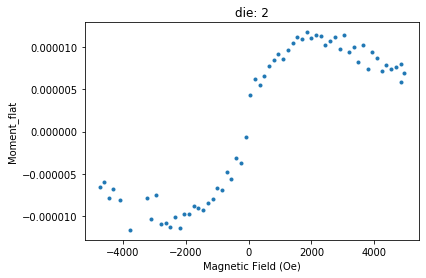

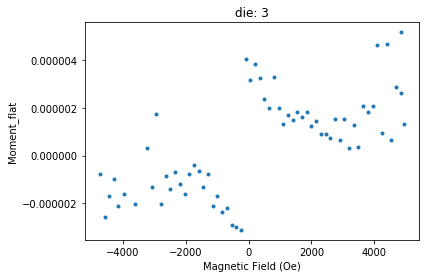

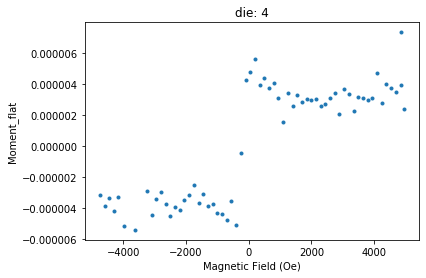

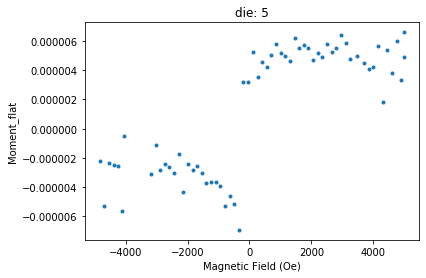

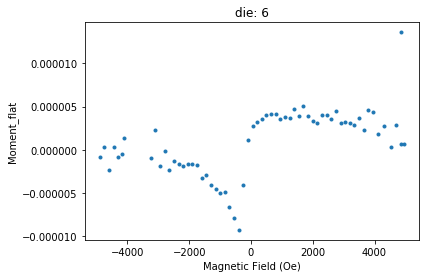

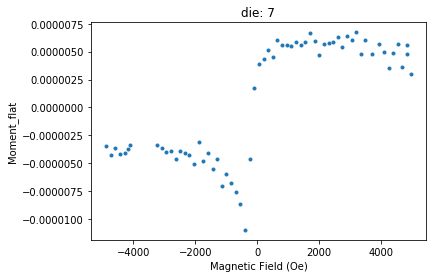

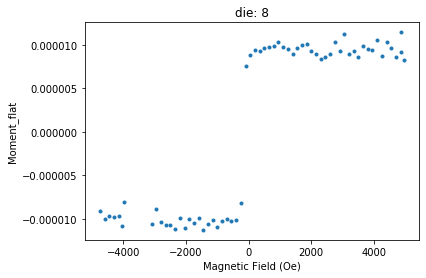

In [11]:
plot_dataset(comb_ds, 'Magnetic Field (Oe)', 'Moment_flat', marker = '.', linestyle = '')

M = 0.9 +/- 0.1 T


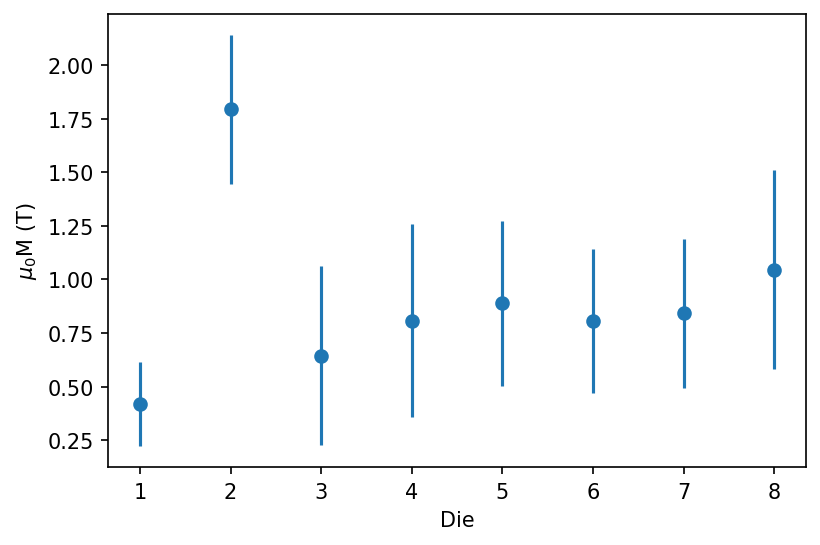

In [14]:
x = comb_ds['die']
y = comb_ds['M']
y_err = comb_ds['M_err']
plt.figure(dpi=150)
plt.errorbar(x, y, y_err, fmt = 'o')
plt.xlabel('Die')
plt.ylabel(r'$\mu$$_0$M (T)')
print(f'M = {np.round(comb_ds.M.where(comb_ds.die >4, drop=True).values.mean(), 1)} +/- {np.round(comb_ds.M.where(comb_ds.die >4, drop=True).values.std(), 1)} T')

### TaPt Van der Pauw

In [15]:
Rs = np.array([8.7, 9.3, 9.5, 9.3])
rho = Rs.mean()*np.pi/np.log(2)*4e-9
rho_err = Rs.std()*np.pi/np.log(2)*4e-9
print(f'{np.round(rho, 8)} +/- {np.round(rho_err, 8)} ohm m')

1.7e-07 +/- 1e-08 ohm m


### TaPt Prepatterned

In [16]:
#Ta(1.5)Pt(6)
R_4620 = 97.35
print(f'rho = {R_4620/46e-6*(20e-6*6e-9)}')

R_6620 = 137.11
print(f'rho = {R_6620/66e-6*(20e-6*6e-9)}')

rho = 2.539565217391305e-07
rho = 2.4929090909090913e-07


In [17]:
#Ta(2)Pt(4)
R_4620 = np.array([172.490, 171.96]).mean()
print(f'rho = {R_4620/46e-6*(20e-6*4e-9)}')

R_6620 = np.array([247.14, 246.47]).mean()
print(f'rho = {R_6620/66e-6*(20e-6*4e-9)}')

rho = 2.9952173913043485e-07
rho = 2.9915757575757576e-07
